# E-mail classification
Service departments are often providing a central e-mailadres to their (internal or external) customers for reporting issues. Often, different topics are handled by different people or departments. Wouldn’t it be great to have an automatic e-mail classifier that forwards e-mails to the right person? Let’s try to make this.  
  
We start from a set of 9.820 real e-mails originating from several e-mail services like monster.com, nieuwsblad.be, datanews.be, etc.. The e-mails belong to four categories: _advertisements_ , _job offerings_ , _news_ and _ICT_ . We’d like to create a classifier that can be used to automatically classify e-mails into one of the four categories ADS, JOB, NEWS and ICT. 
We start by importing and exploring the data. 

In a previous exercise we used word embeddings and a neural network for document classification, but do we really need these advanced and compute-intensive techniques?

Create a model based on based on TFidVectorizer iso word embeddings and use a voting classifier.   

Compare the accuracy of this model to the accuracy of the neural network you created above. 


In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation

import seaborn as sns                               # Advanced data visualisation

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D,  MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model


import nltk


2.8.0


In [2]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
else:
    colab = False
    print ('You are not running on Google Colab')

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

You are not running on Google Colab


Read the files

In [3]:
import numpy as np
import pandas as pd

if colab:
    ads = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailADS.csv',encoding = "ISO-8859-1")
    ict = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailICT.csv',encoding = "ISO-8859-1")
    job = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailJOB.csv',encoding = "ISO-8859-1")
    news = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/emailNEWS.csv',encoding = "ISO-8859-1")
else:
    ads = pd.read_csv('datasets/emailADS.csv',encoding = "ISO-8859-1")
    ict = pd.read_csv('datasets/emailICT.csv',encoding = "ISO-8859-1")
    job = pd.read_csv('datasets/emailJOB.csv',encoding = "ISO-8859-1")
    news = pd.read_csv('datasets/emailNEWS.csv',encoding = "ISO-8859-1")



Merge the 4 panda dataframes into 1 dataframe called data


In [4]:
data = ads.append([ict,job,news])

C:\Users\jcor864\AppData\Local\Temp\ipykernel_21348\3339414562.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = ads.append([ict,job,news])


Combine the columns Subject and Body into 1 column Text  
Keep only the columns Category and Text

In [5]:
data = data[['Subject','Body','Category']]  # we only keep these three columns 
data['Text'] = data['Subject'] + ' ' + data['Body']
data = data.drop(['Subject','Body'],axis=1)
data.head()

,Category,Text
0,ADS,Alles halve prijs - of nog veel goedkoper! <h...
1,ADS,Alles halve prijs - of nog veel goedkoper! <h...
2,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...
3,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...
4,ADS,"Armband met activiteitstracker, Apple iPhone 6..."


Since stop word removal and stemming are language dependent we need first to determine the language of each e-mail and split the data set per language. 
(language detection takes serval minutes)

In [6]:
if colab:
    !pip install langdetect

In [6]:
# language detection - this can take a while
from langdetect import detect
data['Lang'] = data['Text'].apply(detect)

Create the following pivot table with an overview of the number of mails per language.  

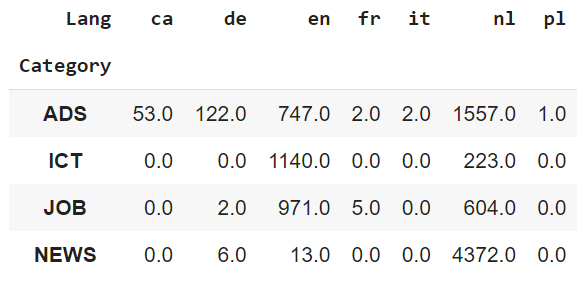

In [7]:
pd.pivot_table(data, values='Text', index=['Category'],columns=['Lang'], aggfunc='count').fillna(0)

Lang,ca,de,en,fr,nl
Category,,,,,
ADS,62.0,121.0,748.0,1.0,1552.0
ICT,0.0,0.0,1140.0,0.0,223.0
JOB,0.0,11.0,970.0,5.0,596.0
NEWS,0.0,4.0,11.0,0.0,4376.0


Keep only the mails in dutch or english

In [8]:
# Using the mails in dutch and english gives a better result (see Exploration 3)
data = data[(data['Lang'] == "nl") | (data['Lang'] == "en")]
data.head()


,Category,Text,Lang
0,ADS,Alles halve prijs - of nog veel goedkoper! <h...,nl
1,ADS,Alles halve prijs - of nog veel goedkoper! <h...,nl
2,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...,nl
3,ADS,Wat krijgen we nu?! Weer EXTRA korting? <http...,nl
4,ADS,"Armband met activiteitstracker, Apple iPhone 6...",nl


Remove dutch stop words and punctuations and use a dutch stemmer (we know we should use the English stemmer or stopwords for the English mails but we ignore this here).

In [9]:
# remove stopwords and punctuations
import nltk
nltk.download('stopwords')
# nltk.download('punkt')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
    
stop_words_nl = set(stopwords.words('dutch')) 

from nltk.stem.snowball import SnowballStemmer

dutchStemmer=SnowballStemmer("dutch")

punctuations="?:!.,;<>/\+-"

# define functions to remove digits stopwords from a string
# I know we are copy-pasting code, but this is for now the simpliest way

def remove_stopwords_nl(s):
    word_tokens = word_tokenize(s.lower()) # turn the string into a list of words based on separators (blank, comma, etc.)
    filtered_sentence = ""
    result = [dutchStemmer.stem(x) for x in word_tokens if x not in stop_words_nl and x not in punctuations]
    seperator = ' '
    return seperator.join(result)

data['Text'] = data['Text'].apply(remove_stopwords_nl)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcor864\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data.head()

,Category,Text,Lang
0,ADS,halv prijs goedkoper https //www.groupon.be/an...,nl
1,ADS,halv prijs goedkoper https //www.groupon.be/an...,nl
2,ADS,krijg we wer extra korting https //www.groupon...,nl
3,ADS,krijg we wer extra korting https //www.groupon...,nl
4,ADS,armband activiteitstracker appl iphon 6/6 plus...,nl


Take a look at the data after the stopwords were removed and the stemmer was applied. A lot of those data contains pieces of what was previously an url. But because those pieces look like //www.groupon.be/analytic/trackintl.gif they won't be part of glove. This "word" will not belong to the vocabulary of word embeddings. 

Therefore replace all punctuation by a space => //www.groupon.be/analytic/trackintl.gif will become www groupon be analytic trackintl gif => groupon will be a word on it's own. Use regular expressions. You can find an example [here](https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace) (use the regex based solution!)

In [11]:
import re

def clean_pieces_urls(piece):
  return re.sub(r"[,.;@#?!&$/=]+\ *", " ", piece)

data['Text'] = data['Text'].apply(clean_pieces_urls)


In [12]:
data.head()

,Category,Text,Lang
0,ADS,halv prijs goedkoper https www groupon be ana...,nl
1,ADS,halv prijs goedkoper https www groupon be ana...,nl
2,ADS,krijg we wer extra korting https www groupon ...,nl
3,ADS,krijg we wer extra korting https www groupon ...,nl
4,ADS,armband activiteitstracker appl iphon 6 6 plus...,nl


How many mails do we have per category?

In [13]:
data.Category.value_counts()

NEWS    4387
ADS     2300
JOB     1566
ICT     1363
Name: Category, dtype: int64

Use a dictionary to replace each of the previous categories with a number 0 .. 3

In [14]:
dict_map = {'NEWS': 0, 'ADS': 1, 'JOB': 2, 'ICT': 3}
data['Category'] = data['Category'].map(dict_map)

In [15]:
data.head()

,Category,Text,Lang
0,1,halv prijs goedkoper https www groupon be ana...,nl
1,1,halv prijs goedkoper https www groupon be ana...,nl
2,1,krijg we wer extra korting https www groupon ...,nl
3,1,krijg we wer extra korting https www groupon ...,nl
4,1,armband activiteitstracker appl iphon 6 6 plus...,nl


What is X_train, y_train, X_test, y_test?

In [16]:
# Extract a training & validation split
from sklearn.model_selection import train_test_split
X = data['Text']
y = data['Category']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)

What is X_train, y_train, X_val, y_val?

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

What are the dimensions of X_train, X_val, X_test, y_train, y_val, y_test?

In [18]:
print("Shape of x_train:", X_train.shape)
print("Shape of x_test:", X_test.shape)
print("Shape of x_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (6153,)
Shape of x_test: (1924,)
Shape of x_val: (1539,)
Shape of y_train: (6153,)
Shape of y_test: (1924,)
Shape of y_val: (1539,)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()

X = vec.fit_transform(X_train)
print(vec.get_feature_names()[:100])
print(X[:20])

['00', '000', '0000', '0000106a0001145', '000025837', '00015c208eec60b3', '000311', '0003fc47335394b4', '00057', '00064812b158bc39f676dab246be4dffa83e3f6aa31', '000b58_0_20180628', '000i', '000m', '000ste', '000th', '001', '0010', '0010_0_20180506', '0016', '0017', '001d', '001xodjf', '002', '0029a040a4', '002b03eda915', '003', '0034465822406596347', '0034f179818', '0034f179818e', '0036izhd2x4l304', '003b9bb9c3', '003buatid0mlfzyrubnqk0qn5jao5scajz5d7r8rjp5dyztdcgr_btpymnyzhtyhxqyemnwt', '003f5c340ee372cf09f0e6fb081f05c6', '003j', '003qno9r', '004', '004211', '004498575159432638', '00458737507', '00489a30a7e969279192', '004ljvpke', '004o2lkh', '005', '0052aed66472', '005385531492320572', '0057b65dd270', '0059c37b5573', '005b93e6a17d80a4', '005umeecivnxsdi5erj456gftfh3fc7t4', '006', '0061903', '0062a046e0782cf0', '0064812b158bc39f676dab246be4dffa83e3f6aa31', '00655217a6', '00661a49b7', '00667', '006_0_20181120', '007', '007ad9082d', '007cc053884eb4a3', '007f89f6', '008', '00813vlqbvu2np

C:\Users\jcor864\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
X_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 6153 entries, 1086 to 851
Series name: Text
Non-Null Count  Dtype 
--------------  ----- 
6153 non-null   object
dtypes: object(1)
memory usage: 96.1+ KB


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')


model = Pipeline([('tfid',TfidfVectorizer()),('voting',voting_clf)])

model.fit(X_train, y_train)
categories = model.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, categories))

0.998960498960499
